# Ankle Quasi Stiffness characterization from human gait data.

The purpose of this notebook is to show the main statitistical results of the ankle quasi-stiffness characterization from human gait data. Here, as a proof of concept, we tried to describe the ankle quasi-stiffness parameters for different anthropomorphical groups as well as many speed instances. More information is described in :

(Reference of my paper)

Herein, ...

## Loading required libraries

In [1]:
from DJSFunctions import extract_preprocess_data, ankle_DJS
from plot_dynamics import plot_ankle_DJS
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats
from utilities_QS import multi_idx, create_df, best_hyper, change_labels
import itertools as it
from itertools import permutations

# stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import seaborn as sns
from scipy.stats.mstats import kruskal
import scikit_posthocs as sp
from statannotations.Annotator import Annotator  # Significant differences
sns.set_context('paper', font_scale=1.5)
sns.set_style("whitegrid")

## Some utilities for statistic calculations

In [2]:

# =============================================================================
# Class to plot the box plots
# =============================================================================

class obt_box_plot:
    def __init__(self, dep_vars, formal_labels, nrows=3, ncols=3, figsize=(12, 12),
                 wspace=0.3, left_space=0.1, labels_take=np.r_[:4, 5:11]):
        self.ncols = ncols
        self.nrows = nrows
        self.fig1, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        self.fig1.tight_layout()
        self.fig1.subplots_adjust(wspace=wspace, left=left_space)
        self.labels_to_take = labels_take
        self.axes = self.trim_axs(self.axes, len(self.labels_to_take))
        self.ax = None
        self.deps_mod_ = dep_vars[self.labels_to_take]
        self.labels_mod_ = np.array(formal_labels)[self.labels_to_take]
        self.hue_order = [] 

    def plot_boxplot(self, varx,  dataset, xlabel, hue='Speed', order=None,
                     hue_order=["VS", 'S', 'C', 'F', 'VF'], legend_pos=4, rot=0):
        self.hue = hue
        self.hue_order = hue_order
        for num,  self.ax in enumerate(np.ravel(self.axes)):
            if num < (self.nrows * self.ncols) - 1:
                sns.boxplot(x=varx, y=self.deps_mod_[num], hue=self.hue,
                            data=dataset, ax=self.ax, hue_order=hue_order, order=order)
                self.ax.set_ylabel(self.labels_mod_[num])
                if num != legend_pos:
                    self.ax.get_legend().remove()
                else:
                    self.ax.legend(loc='lower right')
                self.ax.set_xlabel(xlabel)
                if rot != 0:
                    plt.setp(self.ax.get_xticklabels(), rotation=rot)
            else:
                continue

        return 
    
    def annotate_(self):
        """
        Work in Progress. 
        To generate automatic stats annotations

        Returns
        -------
        None.

        """
        perm = permutations(self.hue_order)
        annotator = Annotator(self.ax, list(perm))
        annotator.set_pvalues()
        

    def trim_axs(self, axs, N):
        """
        Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
        Copied from pyplot webpage
        """
        axs = axs.flat
        for ax in axs[N:]:
            ax.remove()
        return axs[:N]

    def save_fig(self, fig_name, sup_title=False):
        if sup_title:
            self.fig1.suptitle(
                'Variables with statistical differences in OvsT and speed', fontsize=18)
        self.fig1.savefig(fig_name)
        return self.fig1

# =============================================================================
# Function to do test student test
# =============================================================================


def ttest_(ds1, ds2, dep_vars):
    """


    Parameters
    ----------
    ds1 : Dataset 1
    ds2 : Dataset 2
    items : items in a dict format

    Returns
    -------
    None.

    """
    # Assumptions:
    #     1. Independent samples
    #     2. Large enough sample size or observations come from a normally-distributed
    #     population
    #     3. Variances are equal, if not apply weltch test

    # Does the samples come from a normally distributed population
    # Let's perform the Bartetts's test whose Null Hypothesis is that the
    # variances are equal. We will use a significance level of 5.0%, for lower values the null hypothesis is rejected
    # and the variances are not equal

    # Measuring and storing if the samples has the same variance
    var = {item: stats.bartlett(ds1[item],
                                ds2[item]).pvalue for item in dep_vars}
    # Performing the ttest, if not equal it will perform
    ttest_ = {item: stats.ttest_ind(ds1[item], ds2[item],
                                    equal_var=var[item] > 0.05).pvalue for item in dep_vars}
    return var, ttest_


# Testing normal distributions
# For values below 5% the hipothesis is rejected and is non-normal distribution
def shapiro_test(ds, dep_vars, name='No name', df=True):

    if df == True:
        shapiro_ = {item: stats.shapiro(
            ds[item]).pvalue > 0.05 for item in dep_vars}
        shapiro_df = pd.Series(shapiro_, name=name)
        return shapiro_df
    else:
        shapiro_ = {item: stats.shapiro(ds[item]).pvalue for item in dep_vars}
        return shapiro_

# =============================================================================
#    Kruskal Wallis test on ranks
# =============================================================================


def kruskal_groups(ds1, ds2, dep_vars, name):
    kruskal_deps = pd.Series({item: kruskal(ds1[item].values, 
                                              ds2[item].values).pvalue < 0.05 for item in dep_vars})
    kruskal_deps = kruskal_deps.replace(True,1)
    kruskal_deps = kruskal_deps.replace(False,0)
    kruskal_deps.name = name
    return kruskal_deps



## Description and overall statistics

In [3]:
concat_QS = pd.read_csv('https://raw.githubusercontent.com/nikorose87/DJS-GA/master/ConcatDatasets/PostProcessedDatasets.csv', index_col=[0])
concat_QS.head()

,ID.1,Age,AgeGroup,Origin,Gender,Height,Weight,Mode,Speed,LoopDirection,...,initLRP,initDP,initS,initTS,WorkAbs,WorkNet,CP,ERP,LRP,DP
ID,,,,,,,,,,,,,,,,,,,,,
F-S01-O-M-C,F-S01,25.0,YoungAdults,South American,M,172.5,74.3,Overground,C,ccw,...,22.5,41.0,64.5,84.5,0.061,0.185,2.170,2.622,12.808,3.852
F-S01-O-M-F,F-S01,25.0,YoungAdults,South American,M,172.5,74.3,Overground,F,ccw,...,22.0,38.5,62.0,85.5,0.008,0.343,2.720,3.194,-0.044,3.683
F-S01-O-M-S,F-S01,25.0,YoungAdults,South American,M,172.5,74.3,Overground,S,ccw,...,25.5,46.0,65.5,82.5,0.089,0.104,1.535,2.881,10.307,3.896
F-S01-T-M-VS1,F-S01,25.0,YoungAdults,South American,M,172.5,74.3,Treadmill,VS,cw,...,31.5,52.0,67.0,82.5,0.116,0.044,-0.061,3.092,6.679,5.930
F-S01-T-M-VS2,F-S01,25.0,YoungAdults,South American,M,172.5,74.3,Treadmill,VS,cw,...,32.0,49.5,65.5,82.0,0.160,0.016,-0.056,3.480,7.942,5.176


In [4]:
concat_QS.describe()

,Age,Height,Weight,initERP,initLRP,initDP,initS,initTS,WorkAbs,WorkNet,CP,ERP,LRP,DP
count,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000
mean,35.440646,165.317097,63.119535,5.469136,26.783001,45.025958,64.452991,84.834916,0.128871,0.181855,0.206626,2.364296,6.097607,3.003917
std,18.566383,16.182374,16.617950,2.321301,5.374853,5.288689,4.523198,4.119062,0.044948,0.109611,0.587000,1.160705,4.627910,1.445044
min,6.000000,116.601233,18.151368,0.666667,14.000000,25.666667,37.666667,58.000000,0.007000,0.000000,-1.640000,-3.106000,-18.598000,-1.064000
25%,24.000000,157.030428,53.285025,4.333333,22.666667,42.000000,62.500000,83.000000,0.097741,0.095165,-0.123000,1.656000,4.186000,2.004000
50%,31.000000,167.500000,64.650000,5.333333,27.000000,45.000000,64.333333,84.500000,0.128000,0.174595,0.111000,2.174000,6.351000,2.764000
75%,50.000000,176.016667,71.750000,6.333333,30.500000,48.000000,66.333333,86.666667,0.160431,0.255000,0.424000,2.888000,8.605000,3.855000
max,84.000000,192.000000,110.000000,29.666667,48.666667,65.666667,83.333333,94.333333,0.297046,0.537138,2.720000,11.239000,24.898000,17.565000


In [5]:
concat_QS.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1053 entries, F-S01-O-M-C to L-S09-O-F-C6
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID.1           1053 non-null   object 
 1   Age            1053 non-null   float64
 2   AgeGroup       1053 non-null   object 
 3   Origin         1053 non-null   object 
 4   Gender         1053 non-null   object 
 5   Height         1053 non-null   float64
 6   Weight         1053 non-null   float64
 7   Mode           1053 non-null   object 
 8   Speed          1053 non-null   object 
 9   LoopDirection  1053 non-null   object 
 10  initERP        1053 non-null   float64
 11  initLRP        1053 non-null   float64
 12  initDP         1053 non-null   float64
 13  initS          1053 non-null   float64
 14  initTS         1053 non-null   float64
 15  WorkAbs        1053 non-null   float64
 16  WorkNet        1053 non-null   float64
 17  CP             1053 non-null   float64


### Isolating groups (deprecated)

In order to establish differences between metadata parameters, we aisle groups with their unique characteristics.

In [6]:
# Defining the labels to use
dep_vars = concat_QS.columns[10:]
# Unique categories of interest
labels = {col: concat_QS[col].unique() for col in [
    'Mode', 'Speed', 'Origin', 'Gender', 'AgeGroup']}
# Creating the combinations
alllabelNames = sorted(labels)
print(f"Label names set {alllabelNames}")
combinations = it.product(*(labels[Name] for Name in alllabelNames))


# =============================================================================
# Setting individual and specific groups
# =============================================================================

mini_datasets = {}
for comb in combinations:
    name = ''
    for init in comb:
        name += init[0]
    # Acronyms correspond to Agegroup, Gender, Mode, Origin and Speed
    mini_datasets.update({name: concat_QS.query(
        "AgeGroup == '{0}' and Gender == '{1}' and Mode == '{2}' and Origin == '{3}' and Speed == '{4}'".format(*comb))})

# Removing empty datasets
mini_datasets = {k: v for k, v in mini_datasets.items() if v.shape[0] != 0}
# Only overground
mini_ds_over = {k: v for k, v in mini_datasets.items() if k[2] == 'O'}

print(f"Number of combinations obtained from combinations: {len(mini_datasets)}, combinations in overground mode only: {len(mini_ds_over)}")

Label names set ['AgeGroup', 'Gender', 'Mode', 'Origin', 'Speed']
Number of combinations obtained from combinations: 60, combinations in overground mode only: 40


### Shapiro-Wilk tests 

Testing normal distribution with criteria: For values below 5% the hipothesis is rejected and is non-normal distribution

In [12]:
# Comparing Overground and treadmill
overground_ds = concat_QS.query("Mode == 'Overground'")
treadmill_ds = concat_QS.query("Mode == 'Treadmill'")

# As European has no treadmill, the comparison between datasets needs to be done on overground
european_ds = overground_ds.query("Origin == 'European'")
brazilian_ds = overground_ds.query("Origin == 'South American'")

# Groups by age
children_ds = overground_ds.query("AgeGroup == 'Children'")
younga_ds = overground_ds.query("AgeGroup == 'YoungAdults'")
adults_ds = overground_ds.query("AgeGroup == 'Adults'")
elder_ds = overground_ds.query("AgeGroup == 'Elderly'")

# Gender comparison on overground
male_ds = overground_ds.query("Gender == 'M'")
female_ds = overground_ds.query("Gender == 'F'")

In [8]:
main_groups = [overground_ds, treadmill_ds, children_ds, younga_ds, 
               adults_ds, elder_ds, male_ds, female_ds]

main_labels = ['Overground', 'Treadmill', 'Children', 'Young Adults', 'Adults', 'Elderly',
               'Males', 'Females']

norm_groups = pd.concat([shapiro_test(ds, dep_vars,
                        etiquete) for ds, etiquete in zip(main_groups,
                                                          main_labels)], axis=1)
norm_groups

,Overground,Treadmill,Children,Young Adults,Adults,Elderly,Males,Females
initERP,False,False,False,False,False,False,False,False
initLRP,False,False,False,False,False,False,False,False
initDP,False,False,False,False,False,False,False,False
initS,False,False,False,False,False,False,False,False
initTS,False,False,False,False,False,False,False,False
WorkAbs,True,True,True,True,True,True,True,False
WorkNet,False,False,False,False,True,False,False,False
CP,False,False,False,False,False,False,False,False
ERP,False,False,False,False,False,False,False,False
LRP,False,False,False,False,False,False,False,False


The Shapiro-Wilk test applied above demonstrated non-normality in almost all dependent variables, excepting $W_{abs}$.

## Kruskal-Wallis test on ranks

The Shapiro\---Wilk test was applied to verify the normality distribution. For the sake of uniformity, due to non-normality in all dependent variables, the analysis of variance (Kruskal--Wallis test on ranks) was applied to identify differences in init ERP, init LRP, init DP, init S, init TS, $W_{abs}$, $W_{net}$, and stiffnesses CP, ERP, LRP, and DP between groups at the same speed.

As the speed ranges on exeperiments vary between fukuchi and Lencioni, for gender and age groups we compare only the speeds from Slow to Fast as we do not have Very Slow and Very Fast samples in the Lencioni experiment. Then, to not make bias in the Kruskal-Wallis analysis, we only include all speeds comparing treadmill and overground walking.

In [ ]:
# =============================================================================
# Kruskal Wallis test
# =============================================================================

# If true, significant differences are detected
kruskal_gen = pd.concat([kruskal_groups(male_ds.query("Speed == '{}'".format(speed)),
                                        female_ds.query(
                                            "Speed == '{}'".format(speed)),
                                        dep_vars, '{}'.format(speed)) for speed in ['S', 'C', 'F']], axis=1)

#Only children and young adults are compared
kruskal_age_ch = pd.concat([kruskal_groups(children_ds.query("Speed == '{}'".format(speed)), 
                              younga_ds.query("Speed == '{}'".format(speed)),
                             dep_vars, '{}'.format(speed)) for speed in ['S', 'C', 'F']], axis=1)
kruskal_age_ya = pd.concat([kruskal_groups(younga_ds.query("Speed == '{}'".format(speed)), 
                              adults_ds.query("Speed == '{}'".format(speed)),
                             dep_vars, '{}'.format(speed)) for speed in ['S', 'C', 'F']], axis=1)
kruskal_age_a = pd.concat([kruskal_groups(adults_ds.query("Speed == '{}'".format(speed)), 
                              adults_ds.query("Speed == '{}'".format(speed)),
                             dep_vars, '{}'.format(speed)) for speed in ['S', 'C', 'F']], axis=1)
kruskal_age_e = pd.concat([kruskal_groups(adults_ds.query("Speed == '{}'".format(speed)), 
                              elder_ds.query("Speed == '{}'".format(speed)),
                             dep_vars, '{}'.format(speed)) for speed in ['S', 'C', 'F']], axis=1)
kruskal_mode = pd.concat([kruskal_groups(overground_ds.query("Speed == '{}'".format(speed)), 
                              treadmill_ds.query("Speed == '{}'".format(speed)), 
                             dep_vars, '{}'.format(speed)) for speed in ['VS', 'S', 'C', 'F', 'VF']], axis=1)

# Making fancier columns
m_index_krus_gen = pd.MultiIndex.from_product([['Gender'], ['S', 'C', 'F']])
m_index_krus_mode = pd.MultiIndex.from_product(
    [['Mode'], ['VS', 'S', 'C', 'F', 'VF']])
kruskal_gen.columns = m_index_krus_gen
# kruskal_origin.columns = m_index_krus_ori
kruskal_age_ch.columns = pd.MultiIndex.from_product([['Children'],['S', 'C', 'F']])
kruskal_age_ya.columns = pd.MultiIndex.from_product([['YoungAdults'],['S', 'C', 'F']])
kruskal_age_a.columns = pd.MultiIndex.from_product([['Adults'],['S', 'C', 'F']])
kruskal_age_e.columns = pd.MultiIndex.from_product([['Elderly'],['S', 'C', 'F']])
kruskal_mode.columns = m_index_krus_mode
kruskall_all = pd.concat([kruskal_gen, kruskal_mode], axis=1)

### Results for Gender and Walking mode groups

In [9]:
kruskall_all.replace(0,False).replace(1,True)

Gender                 Mode                           
             S      C      F     VS     S      C      F     VF
initERP  False  False   True  False  True   True  False   True
initLRP  False  False  False   True  True   True   True   True
initDP   False  False  False   True  True   True   True   True
initS    False   True  False  False  True   True   True   True
initTS   False   True   True  False  True   True  False  False
WorkAbs  False   True   True  False  True  False  False   True
WorkNet  False  False  False   True  True   True   True  False
CP        True   True   True   True  True   True   True  False
ERP       True   True  False   True  True   True   True  False
LRP       True   True   True  False  True   True  False  False
DP        True   True  False   True  True   True   True   True

### Results comparing age groups

In [10]:
kruskall_age = pd.concat([kruskal_age_ch, kruskal_age_ya,kruskal_age_a, kruskal_age_e], axis=1)
kruskall_age.replace(0,False).replace(1,True)

Children               YoungAdults               Adults                \
               S      C      F           S      C      F      S      C      F   
initERP    False  False  False        True   True  False  False  False  False   
initLRP    False  False  False       False  False   True  False  False  False   
initDP      True  False  False       False  False   True  False  False  False   
initS       True  False  False       False  False   True  False  False  False   
initTS      True   True   True        True   True  False  False  False  False   
WorkAbs    False   True   True        True   True   True  False  False  False   
WorkNet    False  False  False        True  False  False  False  False  False   
CP         False   True   True       False  False   True  False  False  False   
ERP        False  False   True       False  False  False  False  False  False   
LRP        False  False   True       False  False  False  False  False  False   
DP         False   True   True       False  False   True  False  False  False   

        Elderly                
              S      C      F  
initERP    True  False   True  
initLRP   False   True   True  
initDP    False   True   True  
initS     False   True   True  
initTS    False  False   True  
WorkAbs   False  False   True  
WorkNet    True   True  False  
CP        False  False   True  
ERP       False  False  False  
LRP       False  False  False  
DP        False  False  False

## Dunn Posthoc test

The __post hoc__ Dunn's test was implemented to multicompare gait speed (S, C, and F) ranks on the groups.

In [13]:
# =============================================================================
# Dunn Posthoc test
# =============================================================================
dunn_all = {}
for label, sub_group in zip(main_labels, main_groups):
    dunn_T = pd.concat([sp.posthoc_dunn(sub_group,
                                        val_col=item,
                                        group_col='Speed',  # Take out adj for Very classes
                                        p_adjust='holm') for item in dep_vars], axis=0)
    dunn_T.index = pd.MultiIndex.from_product(
        [dep_vars, list(dunn_T.index.unique())])
    dunn_Tbool = sp.sign_table(dunn_T)
    dunn_all.update({label: dunn_Tbool})
dunn_all

{'Overground':               C    F    S   VF   VS
 initERP C     -    *   NS   NS    *
         F     *    -  ***   NS  ***
         S    NS  ***    -   NS   NS
         VF   NS   NS   NS    -   NS
         VS    *  ***   NS   NS    -
 initLRP C    NS   NS   NS   NS   NS
         F    NS   NS   NS   NS   NS
         S    NS   NS   NS   NS   NS
         VF   NS   NS   NS   NS   NS
         VS   NS   NS   NS   NS   NS
 initDP  C    NS   NS  ***   **   **
         F    NS   NS  ***    *  ***
         S   ***  ***   NS  ***   NS
         VF   **    *  ***   NS  ***
         VS   **  ***   NS  ***   NS
 initS   C    NS    *  ***  ***  ***
         F     *   NS  ***    *  ***
         S   ***  ***   NS  ***    *
         VF  ***    *  ***   NS  ***
         VS  ***  ***    *  ***   NS
 initTS  C    NS   NS   NS   NS   NS
         F    NS   NS  ***   NS   NS
         S    NS  ***   NS   NS   NS
         VF   NS   NS   NS   NS   NS
         VS   NS   NS   NS   NS   NS
 WorkAbs C    NS   NS   

### Concatenating all metadata

The following dataset is the compilation of all groups in terms of the 12 independent variables that characterize the ankle QS

In [14]:
# =============================================================================
# Main statistic info
# =============================================================================

# Detecting negative CP and LRP
neg_QS = concat_QS.query("CP < 0 ")
neg_LRP = concat_QS.query("LRP < 0 ")
# Detecting how many were cw
cw_samples = concat_QS.query("LoopDirection == 'cw' ")

idx = pd.IndexSlice
decimal = 3
summary = pd.concat([multi_idx(label, rp.summary_cont(group.groupby(group['Speed']),
                                                      decimals=decimal).T, idx=False) for group,
                     label in zip(main_groups, main_labels)], axis=1)
summary = summary.dropna(axis=1)

trials_num = summary.iloc[0, :].astype(np.int64)
trials_num.name = ('', 'N')
# Dropping non independent vars
summary = summary.loc[idx[dep_vars, :], :]
# Dropping N,and SE
summary = summary.loc[idx[:, ['Mean', 'SD', '95% Conf.', 'Interval']], :]
summary = change_labels(summary, ['Mean', 'SD', '95% CI min', '95% CI max'],
                        index=True, level=1)

summary = pd.concat([pd.DataFrame(trials_num).T, summary], axis=0)
# Changing order on level 1 columns
summary = summary.reindex(summary.index.get_level_values(0).unique(),
                          axis=0, level=0)
summary = summary.reindex(['VS', 'S', 'C', 'F', 'VF'], axis=1, level=1)


# Exporting to latex
vel_labels = ['$v*=0.17(0.02)$', '$v*=0.23(0.03)$',
              '$v*=0.3(0.04)$',  '$v*=0.36(0.04)$',
              '$v*=0.43(0.05)$', '$v*=0.49(0.06)$',
              '$v*=0.56(0.07)$', '$v*=0.62(0.07)$',
              '$v*=0.30(0.04)$', '$v*=0.44(0.05)$',
              '$v*=0.55(0.06)$']

groups = [['Overground', 'Treadmill'],
          ['Children', 'Young Adults', 'Adults', 'Elderly'],
          ['Males', 'Females']]

summary = summary.drop(["95% CI min", "95% CI max"], level=1)
groups_label = ["Environment", "Age", "Sex"]

/home/nikorose/Documents/Repos/DJS-GA/utilities_QS.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df_.index.levels[level].str.replace(idx_old[num], name),


Now, It's time for plotting the results in boxplots

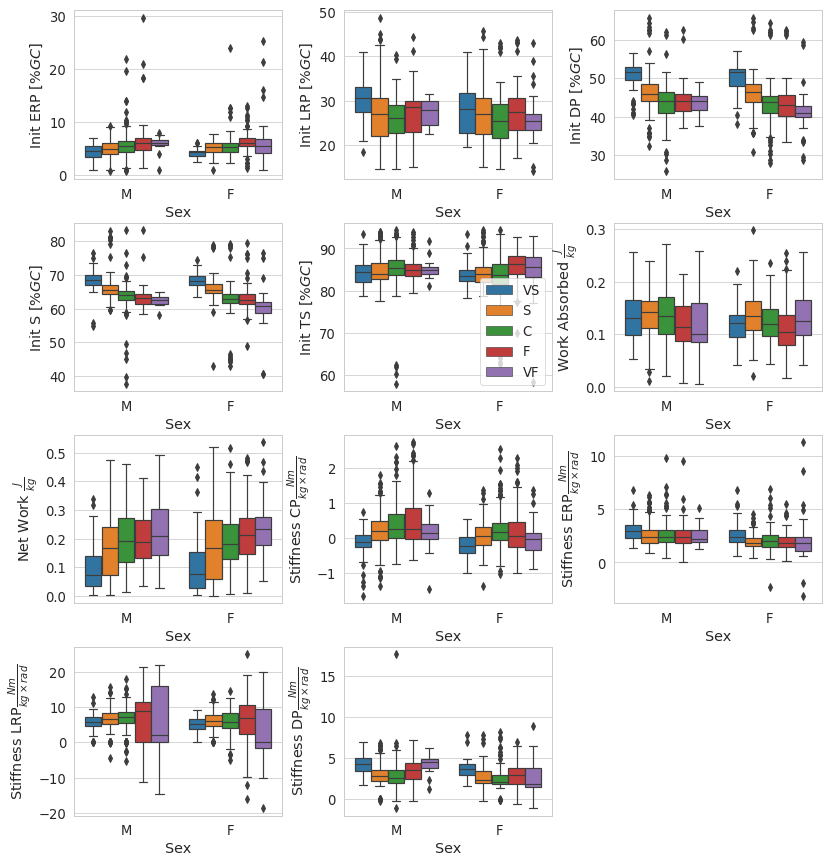

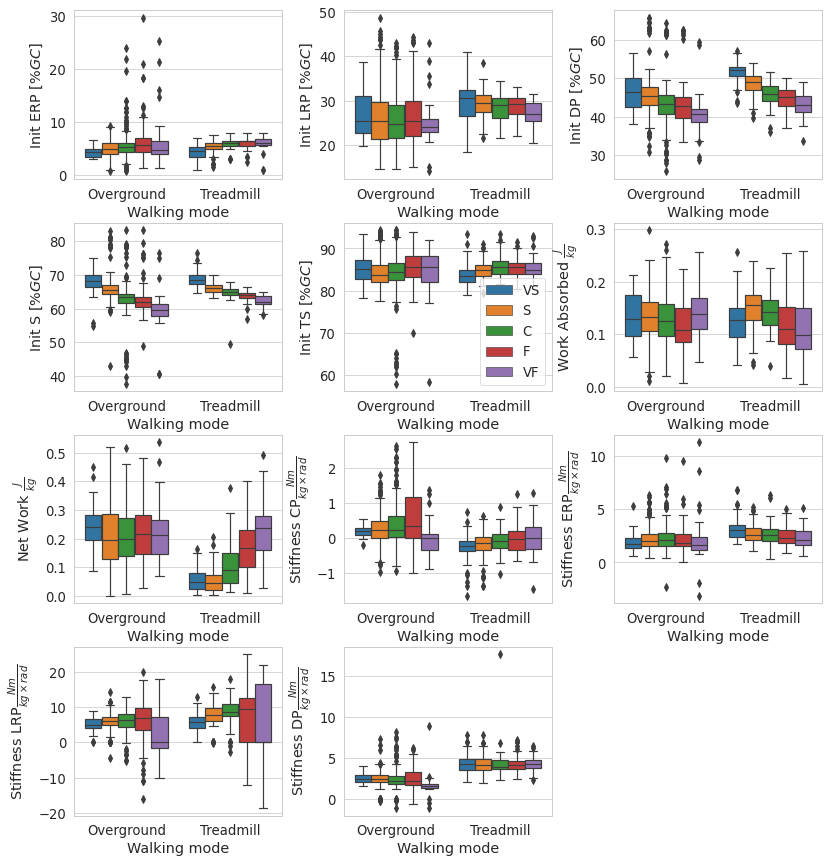

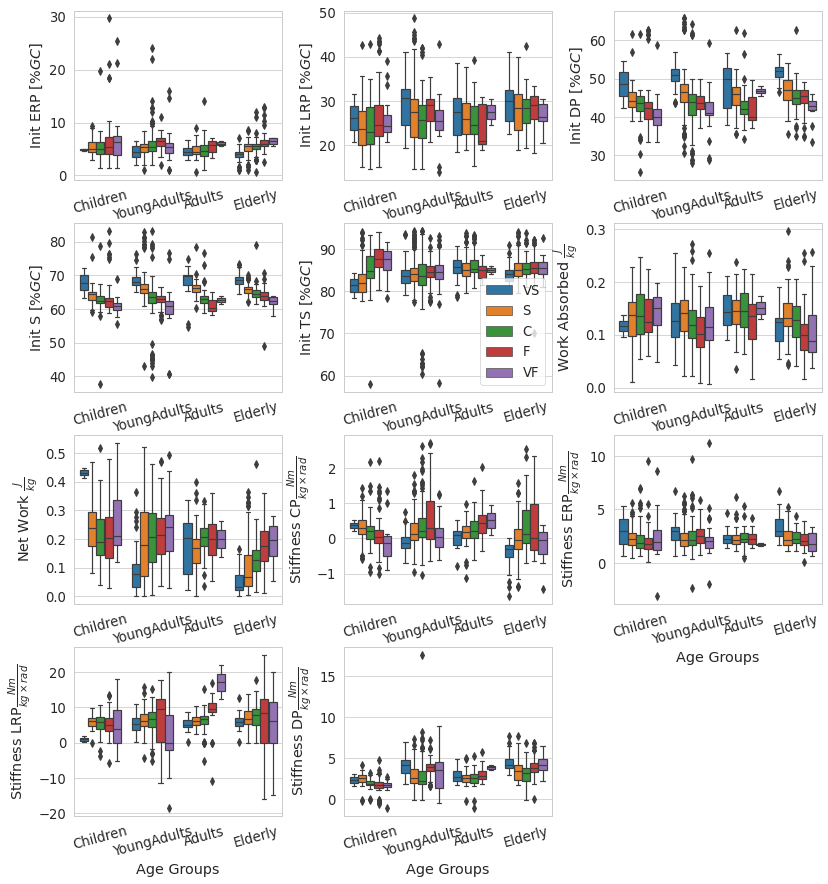

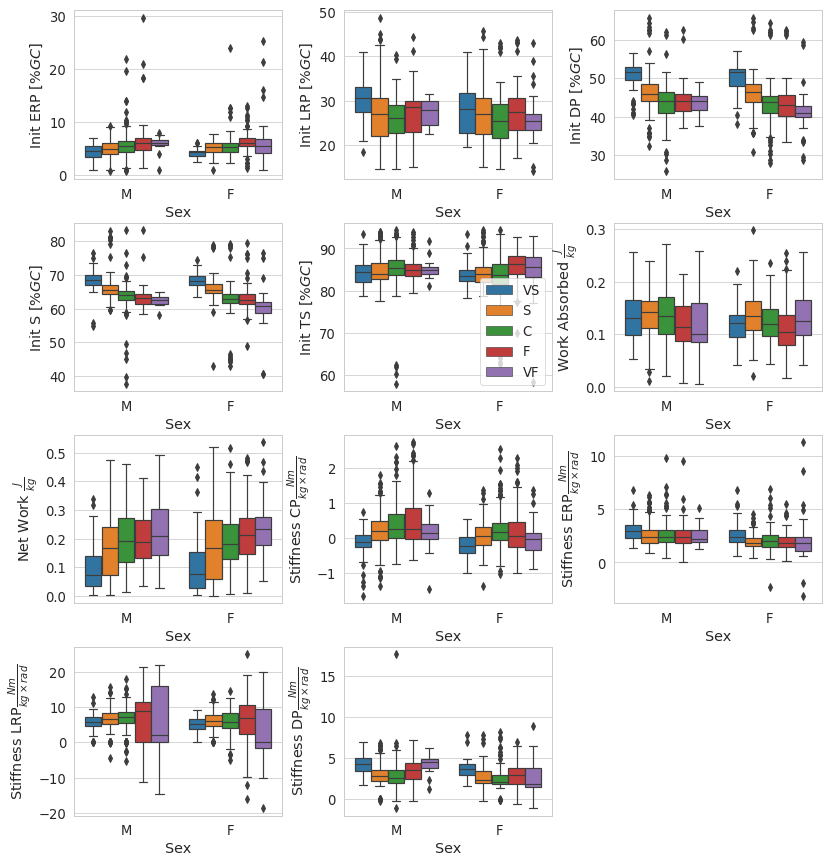

In [15]:
# Building the formal math labels

stiff_labels = ['CP', 'ERP', 'LRP', 'DP']
formal_labels = ['Init {} '.format(
    i)+r'$[\%GC]$' for i in ['ERP', 'LRP', 'DP', 'S', 'TS']]
formal_labels.extend(
    ['Work Absorbed '+r'$\frac{J}{kg}$', 'Net Work '+r'$\frac{J}{kg}$'])
formal_labels.extend(['Stiffness {}'.format(
    stiff)+r'$\frac{Nm}{kg \times rad}$' for stiff in stiff_labels])


# Plotting the overground vs treadmill boxplots
mode_class = obt_box_plot(dep_vars, formal_labels,
                          nrows=4, ncols=3, labels_take=np.r_[:11])
mode_class.plot_boxplot("Mode", dataset=concat_QS, xlabel="Walking mode")
mode_class.save_fig("stats_diff_mode_speed.pdf")

# Plotting the Agegroup boxplots
age_class = obt_box_plot(dep_vars, formal_labels, nrows= 4, ncols = 3, labels_take= np.r_[:11])
age_class.plot_boxplot("AgeGroup", dataset = concat_QS, xlabel = "Age Groups",
                        order = ["Children","YoungAdults","Adults","Elderly"], rot= 15)
age_class.save_fig("stats_diff_age_speed.pdf") #Change angle xlabel, try to visualize in a better way

# Ploting the Gender comparison boxplot
gender_class = obt_box_plot(dep_vars, formal_labels, nrows= 4, ncols = 3, labels_take= np.r_[:11])
gender_class.plot_boxplot("Gender", dataset = concat_QS, xlabel = "Sex")
gender_class.save_fig("stats_diff_gender_speed.pdf") #Change angle xlabel